# Amadeus Data Challenge

## Lorenzo von Ritter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from GeoBases import GeoBase

In [3]:
geo_o = GeoBase(data='ori_por', verbose=False)

In [4]:
%matplotlib inline

###Exercise 1: Count the number of lines

##### We just do it in the shell, so that we don't need to read the csv

######  wc -l searches.csv                 ->           20390198 searches.csv
##### wc -l bookings.csv                   ->           10000011 bookings.csv


### Execise 2: Top 10 airports

##### before importing bookings, remove whitespaces before the delimiter from the original file with 
##### sed 's/\s*^/^/g' bookings.csv > bookingsClean.csv

In [5]:
%%time
# calculate the number of arriving passengers for every airport in the bookings file
airports = []
for chunk in pd.read_csv("../Files/bookingsClean.csv", sep="^", usecols=['arr_port','pax'], dtype={'arr_port': object, 'pax': np.float64}, chunksize=500000):
    airports.append(chunk.groupby('arr_port').pax.count())
airports = pd.concat(airports, axis=1)
columns_list = list(airports)
airports['Arrivals'] = airports.sum(axis=1)
airports.drop(columns_list,axis=1,inplace=True)
airports.sort(columns='Arrivals',inplace=True, ascending=0)

CPU times: user 35.2 s, sys: 4.33 s, total: 39.6 s
Wall time: 1min 10s


In [6]:
%%time
# add the name of the airport and the city to the top list of airports
topAirports = airports.head(10).copy()
topAirports['Name'] = np.nan
topAirports['City'] = np.nan
for airportRowIndex, airportRow in topAirports.iterrows():
    topAirports['Name'][airportRowIndex] = geo_o.get(airportRowIndex, 'name')
    topAirports['City'][airportRowIndex] = geo_o.get(airportRowIndex, 'city_name_ascii')

CPU times: user 5.1 ms, sys: 129 µs, total: 5.23 ms
Wall time: 4.66 ms


In [7]:
topAirports

,Arrivals,Name,City
LHR,215551,London Heathrow Airport,London
JFK,158930,John F Kennedy International Airport,New York City
CDG,149390,Paris - Charles-de-Gaulle,Paris
LAX,143220,Los Angeles International Airport,Los Angeles
DXB,135640,Dubai International Airport,Dubai
BKK,130420,Suvarnabhumi,Bangkok
MIA,117820,Miami International Airport,Miami
SFO,110970,San Francisco International Airport,San Francisco
MNL,109530,Ninoy Aquino Manila International Airport,Manila
ORD,99750,Chicago O'Hare International Airport,Chicago


### Exercise 3: Monthly arrivals in Málaga, Madrid and Barcelona

In [8]:
%%time
specialSearches = pd.DataFrame
specialSearchesList = []
datecount = pd.DataFrame
for chunk in pd.read_csv("../Files/searches.csv", sep="^", usecols=['Date','Time','Destination'], parse_dates=[['Date','Time']], dtype={'Destination': object}, chunksize=500000):
    specialSearches = chunk[(chunk["Destination"] == "AGP") | (chunk["Destination"] == "BCN") | (chunk["Destination"] == "MAD")]
    specialSearches = specialSearches.groupby(['Date_Time','Destination']).Date_Time.count()
    specialSearches = specialSearches.unstack('Destination')
    specialSearchesList.append(specialSearches)
datecount = pd.concat(specialSearchesList)

CPU times: user 8min 43s, sys: 12.7 s, total: 8min 55s
Wall time: 9min 24s


In [9]:
datecount.index = pd.to_datetime(datecount.index)
monthcount = datecount.resample('M', how=sum)
monthcount

Destination,AGP,BCN,MAD
2013-01-31,9633,29469,24258
2013-02-28,8379,28329,22800
2013-03-31,10659,30552,24681
2013-04-30,8265,31236,25251
2013-05-31,10830,28728,26334
2013-06-30,7923,26505,22800
2013-07-31,8892,29241,22971
2013-08-31,7866,27075,21831
2013-09-30,8151,23427,21147
2013-10-31,6499,20276,22294


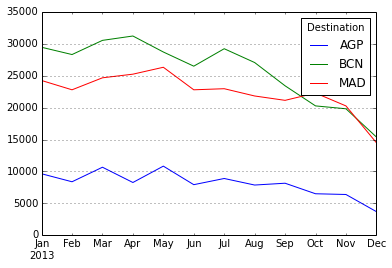

In [10]:
monthcount.plot()

### Exercise 4: Join DataFrames

In [30]:
emptySearches = pd.DataFrame({'Date_Time': [], 'Origin': [], 'Destination': [], 'Booked': []})
emptySearches.to_csv('../Files/bookedSearches.csv', sep='^', index=False, cols=['Date_Time','Origin','Destination','Booked'])

In [31]:
%%time
for search in pd.read_csv("../Files/searches.csv", sep="^", usecols=['Date','Time','Origin','Destination'], parse_dates=[['Date','Time']], dtype={'Origin': object, 'Destination': object}, chunksize=500000):
    search['Booked'] = 0 #add empty column for later
    for booking in pd.read_csv("../Files/bookingsClean.csv", sep="^", usecols=['dep_port','arr_port','pax'], dtype={'dep_port': object, 'arr_port': object, 'pax': np.float64}, chunksize=500000):
        bookedList = (pd.merge(search.reset_index(), booking, left_on=['Origin','Destination'], right_on=['dep_port','arr_port']))['index'].unique()
        search['Booked'][bookedList] = 1 # for booked Searches, change 'Booked' value to 1
    with open('../Files/bookedSearches.csv', 'a') as file:
        search.to_csv(file, mode='a', sep='^', header=False, index=False)

CPU times: user 53min 48s, sys: 9min 23s, total: 1h 3min 11s
Wall time: 1h 20min 38s


In [3]:
emptySearches = pd.DataFrame({'Date_Time': [], 'Origin': [], 'Destination': [], 'Booked': []})
emptySearches.to_csv('../Files/bookedSearches.csv', sep='^', index=False, cols=['Date_Time','Origin','Destination','Booked'])

In [4]:
%%time
for search in pd.read_csv("../Files/searches.csv", sep="^", usecols=['Date','Time','Origin','Destination'], parse_dates=[['Date','Time']], dtype={'Origin': object, 'Destination': object}, chunksize=816000):
    search['Booked'] = 0 #add empty column for later
    for booking in pd.read_csv("../Files/bookingsClean.csv", sep="^", usecols=['dep_port','arr_port','pax'], dtype={'dep_port': object, 'arr_port': object, 'pax': np.float64}, chunksize=770000):
        bookedList = (pd.merge(search.reset_index(), booking, left_on=['Origin','Destination'], right_on=['dep_port','arr_port']))['index'].unique()
        search['Booked'][bookedList] = 1 # for booked Searches, change 'Booked' value to 1
    with open('../Files/bookedSearches.csv', 'a') as file:
        search.to_csv(file, mode='a', sep='^', header=False, index=False)

CPU times: user 47min 18s, sys: 6min 6s, total: 53min 25s
Wall time: 1h 9min 52s


In [11]:
pd.read_csv("../Files/bookedSearches.csv", sep="^", nrows=1000)

,Date_Time,Origin,Destination,Booked
0,2013-01-01 20:25:57,TXL,AUH,1
1,2013-01-01 10:15:33,ATH,MIL,0
2,2013-01-01 18:04:49,ICT,SFO,1
3,2013-01-01 17:42:40,RNB,ARN,1
4,2013-01-01 17:48:29,OSL,MAD,1
5,2013-01-01 22:00:28,IAH,BLR,1
6,2013-01-01 10:47:14,CPH,PAR,0
7,2013-01-01 23:39:49,PAR,DUB,0
8,2013-01-01 17:08:46,DUS,ACE,1
9,2013-01-01 19:57:57,FRA,BGW,1
